# Lecture 13 - Optimizing Selectivity
### This notebook first walks through the steps of finding an optimum reactant concentration that maximizes instantaneous specificity to a desired product in a network of competing reactions, using scipy.optimize.minimize. It then shows the impact of various reactor design choices on overall selectivity.

We focus our discussion around the Trambouze reaction network
1. A --> X (0 order in A) k1 = 0.0001 mol/L-s
2.  A --> B (1st order in A) k2 = 0.0015 1/s
3.  A --> Y (2nd order in A) k3 = 0.008 (L/mol-s)^2

B is the desired product, and we wish to know what concentration of A maximizes the instantaneous selectivity, defined as:

$$\frac{r_2}{r_1+r_3}$$

where i refers to the reaction number. Earlier in class we derived an analytical solution to this problem by writing the rate equation for each reaction, using that to write an expression for the selectivity, and finding the maximum by setting the derivative equal to 0 and solving for the associated $C_A$. Because not all problems of this nature will have a nice analytical solution, here we will use numerical optimization using the scipy.optimize package to find that same $C_A$.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize_scalar #There are two commonly used optimization functions, depending whether your function of inters returns a scalar or a vector.
from scipy.optimize import minimize
%matplotlib inline

In [ ]:
T0 = 300 #K
k1 = 0.0001
k2 = 0.0015
k3 = 0.008

#### Define function to calculate selectivity

In [ ]:
#Define a function that returns the selectivity for a given CA
def trambouze_selectivity(CA, k1, k2, k3):
    C = np.array([CA, CA, CA])
    k = np.array([k1, k2, k3])
    order = np.array([0, 1, 2])
    rate = k*C**order #Calculate the rates in an array
    selectivity = rate[1]/(rate[0]+rate[2])  #Definition of instantaneous selectivity
    return -1*selectivity #Here we are returning -1*selectivity, since minimizing the negative is the same as maximizing the positive

In [ ]:
#Test the function
trambouze_selectivity(0.2, k1, k2, k3)

### Optimizatin using scipy.optimize.minimize_scalar
Since our function is only of one variable, we can use the scalar version of the minimize algorithm. If we were trying to find optimal values of more than one variable, we would use the vector version, as shown later in this demo.

#### Plot selectivity over a reasonable range of concentrations

In [ ]:
#Plot selectivity vs CA over a reasonable range
CA_range = np.linspace(0, 0.5, 50)
selectivity = np.zeros(len(CA_range))
#Use a for loop to calculate the selectivity at each CA in CA_range (this could probably be vectorized, but this is OK for now)
for i in range(len(CA_range)):
        selectivity[i] = trambouze_selectivity(CA_range[i], k1, k2, k3)
 
#Plot the results
plt.plot(CA_range, -1*selectivity)
plt.xlabel(r'$C_A$ (M)')
plt.ylabel('Selectivity')

#### Use minimize_scalar from scipy.optimize to find the value of CA that minimizes our function
Additional documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html

In [ ]:
#Here we call the function minimize_scalar, which at a minimum requries the function to be minized.
#It can also take additional arguments, such as an initial guess, and a tuple of arguments to pass to the function
CA_opt = minimize_scalar(trambouze_selectivity, args = (k1, k2, k3))

In [ ]:
#THe object returned, CA_opt, deserves some attention
CA_opt

In [ ]:
#To extract the optimum x value
CA_opt.x

In [ ]:
#To extract the value of the function at that point
CA_opt.fun

In [ ]:
#Use these to overlay our optimum on the plot

#Plot the originaa data
plt.plot(CA_range, -1*selectivity)

#Overlay
plt.scatter(CA_opt.x, -1*CA_opt.fun, color = 'k')

### Optimization of functions that take a vector input

We could also have use the vectorized version of the function. It's a little silly in this example because we're only optimizing one variable (CA), but in cases where you want to SIMULTANEOUSLY optimize multiple parameters - e.g. let's say you had a rate law that depended on CA and CB - this form will allow you to do that by passsing them in as a vector [CA, CB]

In [ ]:
#Define a function that returns the selectivity for a given CA
#Note we've also defined hte ability to take CB, even though it's not actually used here, for demonstration purposes.
def selectivity_vector(C, k1, k2, k3):
    CA = C[0]
    CB = C[1]
    selectivity = k2*CA/(k1+k3*CA**2)  #Definition of instantaneous selectivity
    return -1*selectivity #Here we are returning -1*selectivity, since minimizing the negative is the same as maximizing the positive

In [ ]:
#Here we call the function minimize_scalar, which at a minimum requries the function to be minized.
#It can also take additional arguments, such as an initial guess, and a tuple of arguments to pass to the function
CA_opt_vector = minimize(selectivity_vector, x0 = [0.2, 0.1], args = (k1, k2, k3))

In [ ]:
CA_opt_vector

### Reactor Design Considerations

In class we discussed how to maximize *overall* selectivity by choosing the correct reactor. We said that the optimal selectivity would be achieved by using a CSTR sized such that effluent concentration was equal to the concentration that gives us the best instantaneous selectivity. Let's look at how to size that reactor, and what the conversion would be.

The relevant design equation:

$$V=\frac{v_0(C_{A0}-C_A)}{-r_A}$$

We are given $v_0$ and $C_{A0}$ as 2 L/s and 0.4M, respectively

In [ ]:
v0 = 2. #L/s
C_inlet = [0.4, 0, 0, 0]

In [24]:
def CSTR(CA, C0): #Take a target concentration of A and initial concentrations and return the necessary volume for that CSTR, the conversion, and the overall selectivity
    CA0, CX0, CB0, CY0 = C0
    rA = k1+k2*CA+k3*CA**2 #negative rA
    V = v0*(CA0-CA)/rA
    X = (CA0-CA)/CA0
    CX = (v0*CX0+V*k1)/v0
    CB = (v0*CB0+V*k2*CA)/v0
    CY = (v0*CY0+V*k3*CA**2)/v0
    S_tilde = CB/(CX+CY)
    print(f'For CA0 = {CA0:.2f}, CA = {CA:.3f}M, V = {V:.0f} L, X = {X:.2f}, and S = {S_tilde:.3f}')
    return CA, CX, CB, CY

CSTR(0.11, C_inlet)
CSTR(0.04, C_inlet)
CSTR(0.01, C_inlet)
CSTR(0.2, C_inlet)

For CA0 = 0.40, CA = 0.110M, V = 1603 L, X = 0.73, and S = 0.838
For CA0 = 0.40, CA = 0.040M, V = 4167 L, X = 0.90, and S = 0.532
For CA0 = 0.40, CA = 0.010M, V = 6736 L, X = 0.97, and S = 0.149
For CA0 = 0.40, CA = 0.200M, V = 556 L, X = 0.50, and S = 0.714


(0.2, 0.027777777777777773, 0.08333333333333331, 0.08888888888888889)

We can see that the conversion that produces optimal selectivity is 0.73. If we push beyond that in the CSTR, the selectivity drops, because the entire system is running at at the lower concentration of CA, which produces suboptimal selectivity. So, what if we really wanted higher conversion than 0.73 (e.g. final CA of 0.01), but wanted to keep selectivity as high as possible? Once the concentration drops below the optimal (0.11M), it is best to keep it as high as possible. Let's try a second CSTR

In [25]:
CSTR(0.04, C_inlet)

For CA0 = 0.40, CA = 0.040M, V = 4167 L, X = 0.90, and S = 0.532


(0.04, 0.20833333333333337, 0.12500000000000003, 0.02666666666666667)

In [26]:
CSTR(0.04, CSTR(0.11, C_inlet))

For CA0 = 0.40, CA = 0.110M, V = 1603 L, X = 0.73, and S = 0.838
For CA0 = 0.11, CA = 0.040M, V = 810 L, X = 0.64, and S = 0.770


(0.04, 0.12066404090657823, 0.15656094527363185, 0.08277501381978994)

We see the an increase in overall selectivity (0.77 vs 0.532), and it now takes us less total reactor volume to get there. How about instead we had used a **PFR** to further convert the effluent from the CSTR?

In [ ]:
from scipy.integrate import odeint

In [ ]:
def deriv(C, V):
    CA, CX, CB, CY = C
    dCAdV = -(k1+k2*CA+k3*CA**2)/v0
    dCXdV = k1/v0
    dCBdV = k2*CA/v0
    dCYdV = k3*CA**2/v0
    return dCAdV, dCXdV, dCBdV, dCYdV

In [ ]:
def PFR(C_in, CA_target): #Take input concentrations of A, B, X, and Y, and calculate outputs, for a target output concentrations
    V_range = np.linspace(0, 1500, 100)
    sol = np.asarray(odeint(func = deriv, y0 = C_in, t = V_range)) #Integrate PFR mole balance
    
    #PLot PFR trajectory
    labels = ['CA', 'CX', 'CB', 'CY']
    plt.figure()
    for col in range(sol.shape[1]): 
        plt.plot(V_range, sol[:,col], label=labels[col])
    plt.legend()
    plt.xlabel('V (L)')
    plt.ylabel('Concentration (M)')
    
    #Find the volume where CA = CA_target, and report the other species concentrations at that point
    for i in range(len(sol[:,0])):
        if sol[i,0] <= CA_target:
            V = V_range[i]
            CA, CX, CB, CY = sol[i,:]
            break
            
    S_tilde = CB/(CX+CY)
    print(f'For an inlet with CA = {float(C_in[0]):.2f} and target CA of {CA_target:.2f}, S = {S_tilde:.2f}')
    return V, CA, CX, CB, CY
    

For CA0 = 0.40, CA = 0.110M, V = 1603 L, X = 0.73, and S = 0.838
For an inlet with CA = 0.11 and target CA of 0.04, S = 0.82


(575.7575757575758,
 0.03879164594148782,
 0.10894266043519772,
 0.16245673680240155,
 0.0898089568209129)

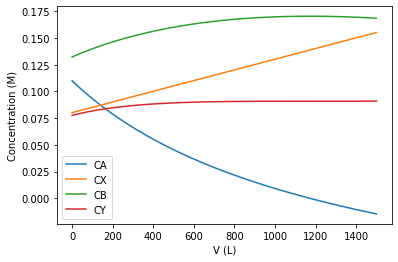

In [27]:
##Run the CSTR to optimal conversion, then feed to a PFR
C_in = CSTR(0.11, C_inlet)
PFR(C_in, 0.04)

So, by using a PFR downstream of the CSTR sized to produce optimal selectivity, we can get a total conversion of 0.9 with a selectivity of **0.82**. What if we'd just used one PFR?

For an inlet with CA = 0.40 and target CA of 0.04, S = 0.64


(1257.5757575757577,
 0.03936184831428717,
 0.06287878787878787,
 0.14094849700262743,
 0.1568108668042974)

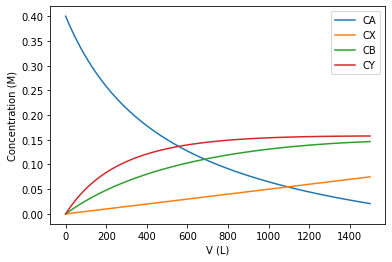

In [28]:
PFR(C_inlet, 0.04)

This case gives us an overall selectivity of 0.64

Comparing all three results for X = 0.9:
* One CSTR: $\tilde{S} = 0.532$
* One PFR: $\tilde{S} = 0.64$
* Two CSTRs, the first designed for optimal selectivity, the second for conversion to 0.9: $\tilde{S} = 0.77$
* A CSTR (designed for optimal selectivity), then a PFR: $\tilde{S} = 0.82$

All of this can be predicted from the initial plot of instantaneous selectivity vs $C_A$. Conversion is represented by moving from *right to left* (concentratino of A goes down over the course of reaction). In the upward-sloping part of the curve, selecitivy is low at high concentration, and high at low concentration. So, it makes sense to use a CSTR, because CA is instantly diluted to the exit concentration. If we had used a PFR instead, the high concentration would have led to a faster generation of Y (since it's second order). 

For the downward sloping part of hte curve, now the situation is reversed, and selectivity is maximized at high concentration. So, it makes sense to use a PFR for this portion to keep the concentration of CA high in the early part of the reactor.